In [151]:
import numpy as np
import cPickle as pickle
import pandas as pd
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import random

In [42]:
meanSentiment_Thirds = "../Final_features/Third_median_sentiments.csv"
mean_sentiment = "../Final_features/mean_sentiments.csv"
aesthetic_csv = "../Final_features/total_aesthetic.pk"
aesthetic_csv_Thirds = "../Final_features/Thirds_aesthetic_thirds.pk"
audiopop_csv = "../Final_features/popAudio_features.csv"
audioUnpop_csv = "../Final_features/unpopAudioFeatures.csv"
socialFeatures = "../Final_features/postSocialMetaFeatures_revised.pk"
popularFile = "../Final_features/popularFaceCounts.pk"
unpopularFile = "../Final_features/unpopularFaceCounts.pk"

In [43]:
def readFeatureFile(color_features):
    with open(color_features) as g:
        featureLines = g.readlines()
    print len(featureLines)
    return featureLines


def readFaceCounts(fileName):
    lists = []
    infile = open(fileName, 'rb')
    while True:
        try:
            lists.append(pickle.load(infile))
        except EOFError:
            infile.close()
            break
    return lists

def removeDuplicatesAndSplit(lines):
    posts = []
    totFrames = []
    faceFrames = []
    profiles = []
    frontals = []
    for l in lines:
        comps = l.split(',')
        postId = comps[0]
        if postId in posts:
            break
        else:
            posts.append(postId)
            if int(comps[1]) == 0:
                totFrames.append(1)
            else:
                totFrames.append(int(comps[1]))
            faceFrames.append(int(comps[2]))
            profiles.append(int(comps[3]))
            frontals.append(int(comps[3]))
    return totFrames, faceFrames , posts
            

def readAudioFeatures(lines):
    featureDict = {}
    
    for line in lines:
        components = line.strip().split(',')
        postId = components[0].strip().split('.')[0]
        feats = [float(x) for x in components[1:]]
        cleanFeats = []
        for x in feats:
            if str(x) != 'nan':
                cleanFeats.append(float(x))
            else:
                cleanFeats.append(0.0)
        featureDict[postId] = cleanFeats
            
    return featureDict

def readSentiFeatures(lines):
    sentiDict = {}
    for line in lines:
        comp = line.split(',')
        sentiDict[comp[0]] = float(comp[1].strip())
    return sentiDict

def mergeAllFeatures(aesthetic , sentiment , audio , social , face):
    totalMatrix = []
    for aes in aesthetic:
        if aes[0] in sentiment:
            if aes[0] in audio:
                if aes[0] in social:
                    if aes[0] in face:
                        postid = aes[0]
                        aesVec = np.asarray(map(lambda x: float(x),aes[1:]) , dtype = "float32").reshape((1,-1))
                        audioVec = np.asarray(map(lambda x: float(x),audio[postid]) , dtype = "float32").reshape((1,-1))
                        sentimentVec = np.asarray(map(lambda x: float(x),[sentiment[postid]]) , dtype = "float32").reshape((1,-1))
                        faceVec = np.asarray(map(lambda x: float(x),[face[postid]]) , dtype = "float32").reshape((1,-1))
                        socialVec = np.asarray(map(lambda x: int(x),social[postid]) , dtype = "int32" ).reshape((1,-1))

                        finalFeatureVec = np.concatenate((aesVec,audioVec,sentimentVec,faceVec, socialVec), axis = 1)
                        totalMatrix.append(finalFeatureVec)
    print len(totalMatrix)
    return np.vstack(totalMatrix)

def convertToDict(social):
    socialDict = {}
    print len(social)
    for i in social:
        social_feats = i[1:]
        key = i[0]
        socialDict[key] = social_feats 
    return socialDict

def faceConvertToDict(destDict , postList , percentageList):
    for i in range(len(postList)):
        destDict[postList[i]] = percentageList[i]
    return destDict

In [44]:
popFaceLines = readFaceCounts(popularFile)
print len(popFaceLines)
unpopFaceLines = readFaceCounts(unpopularFile)
print len(unpopFaceLines)

11448
12000


In [45]:
popTotFrames , popFaceFrames , popPosts = removeDuplicatesAndSplit(popFaceLines)
facePercentages = np.zeros((len(popTotFrames),1))
for i in range(len(facePercentages)):
    facePercentages[i] = float(float(popFaceFrames[i])/float(popTotFrames[i]))
unpopTotFrames , unpopFaceFrames , unpopPosts = removeDuplicatesAndSplit(unpopFaceLines)
unpopfacePercentages = np.zeros((len(unpopTotFrames),1))
for i in range(len(unpopfacePercentages)):
    unpopfacePercentages[i] = float(float(unpopFaceFrames[i])/float(unpopTotFrames[i]))

In [46]:
faceDict = faceConvertToDict({}, popPosts , facePercentages)
faceDict = faceConvertToDict(faceDict, unpopPosts , unpopfacePercentages)
print len(faceDict.keys())

23448


In [47]:
f = open(aesthetic_csv , "r+")
aesFeats = pickle.load(f)
f.close()


In [48]:
f = open(aesthetic_csv_Thirds , "r+")
aesFeats_Thirds = pickle.load(f)
f.close()

In [49]:
print aesFeats.shape, aesFeats_Thirds.shape

(18474, 20) (18474, 20)


In [50]:
f = open(socialFeatures , "r+")
socialFeats = pickle.load(f)
f.close()
print socialFeats[104]

['1294156026651774976', 835975, 241, 568489.0, 18158, 5979]


In [51]:
popAudio_csv = readFeatureFile(audiopop_csv)

11446


In [52]:
unpopAudio_csv = readFeatureFile(audioUnpop_csv)

11992


In [53]:
totalFeats = popAudio_csv + unpopAudio_csv
audioDict = readAudioFeatures(totalFeats)

In [54]:
ex =  audioDict['1381729172183040000']

In [55]:
print ex

[0.0, 0.16844, 40.915827, 0.10944, 0.7735, 0.333333]


In [56]:
senti_csv = readFeatureFile(meanSentiment)
sentiDict = readSentiFeatures(senti_csv)

23441


In [57]:
senti_csv_Thirds = readFeatureFile(meanSentiment_Thirds)
sentiDictThirds = readSentiFeatures(senti_csv_Thirds)

23441


In [59]:
sentiDict['1381729172183040000'] , sentiDictThirds['1381729172183040000']

(3.6, 3.6)

In [60]:
print socialFeats[1:10]

[['1379007357325344768', 33, 258, 18.0, 2, 0], ['1384812946315706368', 183, 86, 14.0, 1, 0], ['1380550788883312640', 0, 1, 4.0, 0, 0], ['1381683778946232320', 113, 57, 6.0, 0, 0], ['1379179530505383936', 175, 174, 3.0, 1, 0], ['1386151370364739584', 427, 105, 3.0, 0, 0], ['1286103711319764992', 51027, 389, 673549.0, 21849, 8150], ['1382613942450405376', 136, 167, 14.0, 1, 0], ['1380365152318537728', 4, 11, 5.0, 0, 0]]


In [61]:
socialDict = convertToDict(socialFeats)

22192


In [62]:
print socialDict[socialDict.keys()[1]]

[152, 78, 3.0, 0, 0]


In [233]:
totMatrix = mergeAllFeatures(aesFeats , sentiDict , audioDict , socialDict , faceDict)
totMatrix_thirds = mergeAllFeatures(aesFeats_Thirds , sentiDictThirds , audioDict , socialDict , faceDict)

16431
16431


In [234]:
totMatrix.shape

(16431, 32)

In [235]:
fudgePopMAtrix = totMatrix[np.where(totMatrix[:,-1] > 434)]

In [236]:
print fudgePopMAtrix.shape

(4036, 32)


In [237]:
fudgeUnpopMatrix = totMatrix[np.where(totMatrix[:,-1] < 434)][:fudgePopMAtrix.shape[0]]

In [238]:
print fudgeUnpopMatrix.shape

(4036, 32)


In [239]:
fudgeMatrix = np.vstack((fudgePopMAtrix, fudgeUnpopMatrix))
print fudgeMatrix.shape

(8072, 32)


In [240]:
FeatureMatrix = totMatrix[:,:-3] 
labelNumbers = totMatrix[:,-3:]

In [241]:
FeatureMatrix_thirds = totMatrix_thirds[:,:-3] 
labelNumbers_thirds = totMatrix_thirds[:,-3:]

In [242]:
print FeatureMatrix.shape , labelNumbers.shape

(16431, 29) (16431, 3)


In [243]:
print np.median(labelNumbers[:][2])

42505.0


In [244]:
#scipy.stats.pearsonr(FeatureMatrix[:][27] , labelNumbers[:][28])

In [245]:
medianPopReposts = 2173.0
meanPopReposts = 16064.0

medianPopLikes = 7544.0
meanPopLikes = 42521.0

medianPopLoops = 318566.0
meanPopLoops = 2405671.0

In [246]:
def createLabels(labelNumbers , variable , threshold , scalar):
    Labels = np.zeros(labelNumbers.shape[0])
    for i in range(labelNumbers.shape[0]):
        if labelNumbers[i][variable] > (scalar*threshold):
            Labels[i] = 1
    return Labels

def balanceDataset(featureMatrix , BinaryLabels):
    positiveSamples = np.where(BinaryLabels[:] > 0)[0]
    negativeSamples = np.where(BinaryLabels[:] == 0)[0]
    sampledNegs = random.sample(negativeSamples, len(positiveSamples) )
    posFeats = featureMatrix[positiveSamples,:]
    negFeats = featureMatrix[sampledNegs,:]
    
    posLabels = BinaryLabels[positiveSamples]
    negLabels = BinaryLabels[sampledNegs]
    #print posFeats.shape , negFeats.shape , posLabels.shape , negLabels.shape
    balancedFeats = np.concatenate((posFeats,negFeats), axis = 0)
    balancedLabels = np.concatenate((posLabels,negLabels), axis = 0)
    #print balancedFeats.shape , balancedLabels.shape
    return balancedFeats,balancedLabels
    
def iterateTraining(FeatureMatrix , labelNumbers , variable , start , stop , steps):
    intervals = (stop-start)/steps
    divisions = np.arange(start, stop , intervals )
    fscores = []
    precisions = []
    recalls = []
    feature_importance = []
    accuracies = []
    errors = []
    for d in divisions: 
        LoopLabels = createLabels(labelNumbers ,  variable , d , 1)
        #print LoopLabels.shape
        #print FeatureMatrix.shape
        balancedX, balancedY = balanceDataset(FeatureMatrix , LoopLabels)
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(balancedX, balancedY, test_size=0.1, random_state=0)
        clfRF = RandomForestClassifier(n_estimators=1000 , max_features = 'sqrt', random_state = 9386)
        clfRF.fit(X_train, y_train)
        RF_predict = clfRF.predict(X_test)
        
        print "Videos Classified as Popular %f at Threshod %f "%(np.sum(LoopLabels)/LoopLabels.shape[0],d)
        
        error_RF = mean_squared_error(y_test, RF_predict)
        errors.append(error_RF)
        
        accuracy = np.mean(y_test == RF_predict)
        accuracies.append(accuracy)
        
        feature_importance.append(clfRF.feature_importances_)
        
        precision , recall , fscore , _ = precision_recall_fscore_support(y_test, RF_predict, average='binary')
        fscores.append(fscore)
        precisions.append(precision)
        recalls.append(recall)
        
    return accuracies, errors , fscores, precisions, recalls,  np.vstack(feature_importance)

def findIterativeCorrelations(FeatureMatrix , LabelNumbers , variable, control, start , stop , steps ):
    intervals = (stop-start)/steps
    divisions = np.arange(start, stop , intervals )
    correlations = []
    pValues = []
    for i in divisions: 
        LoopLabels = createLabels(labelNumbers ,  variable , i , 1)
        corrs = scipy.stats.pointbiserialr(LoopLabels , FeatureMatrix[:,control])
        correlations.append(corrs[0])
        pValues.append(corrs[1])
    return correlations, pValues
        
    

In [247]:
accuracies_total, errors_total , fscores_total, precision_total, recall_total, feature_importance_total  = \
iterateTraining(FeatureMatrix , labelNumbers , 0 , 80.0 , 1.7*medianPopLoops , 30)

Videos Classified as Popular 0.337898 at Threshod 80.000000 
Videos Classified as Popular 0.318544 at Threshod 18129.406667 
Videos Classified as Popular 0.284219 at Threshod 36178.813333 
Videos Classified as Popular 0.258962 at Threshod 54228.220000 
Videos Classified as Popular 0.240886 at Threshod 72277.626667 
Videos Classified as Popular 0.226158 at Threshod 90327.033333 
Videos Classified as Popular 0.211916 at Threshod 108376.440000 
Videos Classified as Popular 0.200414 at Threshod 126425.846667 
Videos Classified as Popular 0.189642 at Threshod 144475.253333 
Videos Classified as Popular 0.179539 at Threshod 162524.660000 
Videos Classified as Popular 0.169497 at Threshod 180574.066667 
Videos Classified as Popular 0.162193 at Threshod 198623.473333 
Videos Classified as Popular 0.154890 at Threshod 216672.880000 
Videos Classified as Popular 0.148074 at Threshod 234722.286667 
Videos Classified as Popular 0.141988 at Threshod 252771.693333 
Videos Classified as Popular 0.135

In [248]:
accuracies_total_thirds, errors_total_thirds , fscores_total_thirds, precision_total_thirds, recall_total_thirds,\
feature_importance_total_thirds  = \
iterateTraining(FeatureMatrix_thirds , labelNumbers_thirds , 0 , 80.0 , 1.7*medianPopLoops , 30)

Videos Classified as Popular 0.337898 at Threshod 80.000000 
Videos Classified as Popular 0.318544 at Threshod 18129.406667 
Videos Classified as Popular 0.284219 at Threshod 36178.813333 
Videos Classified as Popular 0.258962 at Threshod 54228.220000 
Videos Classified as Popular 0.240886 at Threshod 72277.626667 
Videos Classified as Popular 0.226158 at Threshod 90327.033333 
Videos Classified as Popular 0.211916 at Threshod 108376.440000 
Videos Classified as Popular 0.200414 at Threshod 126425.846667 
Videos Classified as Popular 0.189642 at Threshod 144475.253333 
Videos Classified as Popular 0.179539 at Threshod 162524.660000 
Videos Classified as Popular 0.169497 at Threshod 180574.066667 
Videos Classified as Popular 0.162193 at Threshod 198623.473333 
Videos Classified as Popular 0.154890 at Threshod 216672.880000 
Videos Classified as Popular 0.148074 at Threshod 234722.286667 
Videos Classified as Popular 0.141988 at Threshod 252771.693333 
Videos Classified as Popular 0.135

In [265]:

steps = 30
m = np.array(np.arange(0 , 1.9*medianPopLoops , 20000 ))
x = m[:-1]
y = np.arange(0,1.1,0.1)

30


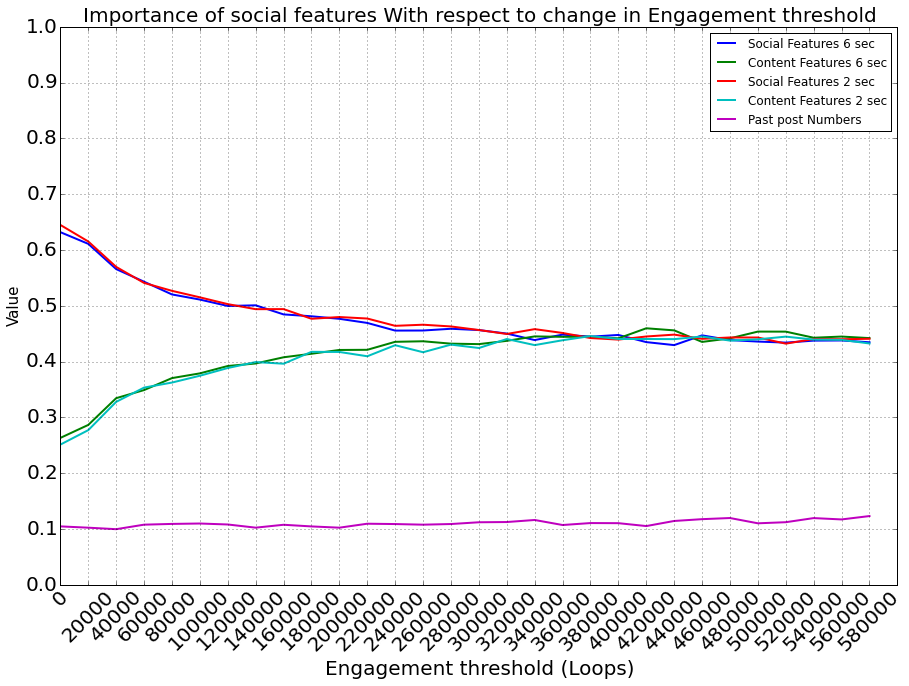

In [268]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Importance of social features With respect to change in Engagement threshold", fontsize = 20)
plt.xlabel("Engagement threshold (Loops)",fontsize = 20)
plt.ylabel("Value",fontsize = 15)


content_feature_importance = [np.sum(feature_importance_total[i,:27]) for i in range(feature_importance_total.shape[0])]
social_feature_importance = [np.sum(feature_importance_total[i,27]) for i in range(feature_importance_total.shape[0])]
post_feature_importance = [np.sum(feature_importance_total[i,28]) for i in range(feature_importance_total.shape[0])]

content_feature_importance_thirds = [np.sum(feature_importance_total_thirds[i,:27]) for i in range(feature_importance_total_thirds.shape[0])]
social_feature_importance_thirds = [np.sum(feature_importance_total_thirds[i,27]) for i in range(feature_importance_total_thirds.shape[0])]
post_feature_thirds_importance = [np.sum(feature_importance_total[i,28]) for i in range(feature_importance_total_thirds.shape[0])]

print len(content_feature_importance)

#plt.plot(x , feature_importance_total[:,26],linewidth = 1.5)
plt.plot(x , social_feature_importance,linewidth = 2)
plt.plot(x , content_feature_importance,linewidth = 2)
plt.plot(x , social_feature_importance_thirds,linewidth = 2)
plt.plot(x , content_feature_importance_thirds,linewidth = 2)
plt.plot(x , post_feature_importance,linewidth = 2 , linestyle = '-')

plt.xticks( x ,rotation=45,fontsize =  20  )
plt.yticks(y , fontsize =  20 )
plt.grid(True)
plt.legend(['Social Features 6 sec', 'Content Features 6 sec' 
            ,'Social Features 2 sec' , 'Content Features 2 sec' ,
            'Past post Numbers'
           ])
plt.show()

30


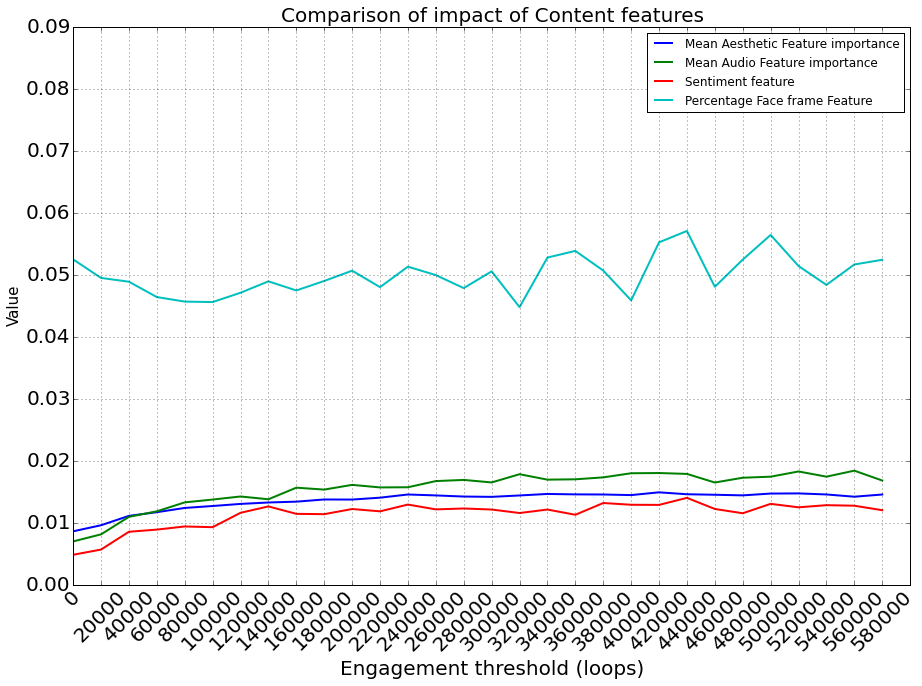

In [274]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of impact of Content features", fontsize = 20)
plt.xlabel("Engagement threshold (loops)",fontsize = 20)
plt.ylabel("Value",fontsize = 15)

aesthetic_feature_importance = [np.mean(feature_importance_total[i,:19]) for i in range(feature_importance_total.shape[0])]
indexAesthetic =  [np.argmax(feature_importance_total[i,:19]) for i in range(feature_importance_total.shape[0])]
#aesthetic_feature_importance = aesthetic_feature_importance / np.max(aesthetic_feature_importance)

audio_feature_importance = [np.mean(feature_importance_total[i,19:25]) for i in range(feature_importance_total.shape[0])]
indexAudio = [np.argmax(feature_importance_total[i,19:25]) for i in range(feature_importance_total.shape[0])]
#audio_feature_importance = audio_feature_importance / np.max(audio_feature_importance)

sentiment_feature_importance = [feature_importance_total[i,25] for i in range(feature_importance_total.shape[0])]

face_feature_importance = [feature_importance_total[i,26] for i in range(feature_importance_total.shape[0])]
#sentiment_feature_importance = sentiment_feature_importance/ np.max(sentiment_feature_importance)

print len(content_feature_importance)
#x = np.array(np.arange(0.2*medianPopReposts , 1.5*medianPopReposts , (1.5*medianPopReposts-0.2*medianPopReposts)/steps))

plt.plot(x , aesthetic_feature_importance,linewidth = 2)
plt.plot(x , audio_feature_importance,linewidth = 2)
plt.plot(x , sentiment_feature_importance,linewidth = 2)
plt.plot(x , face_feature_importance,linewidth = 2)



plt.yticks(np.arange(0,0.11,0.01) , fontsize =  20 )
plt.xticks( x ,rotation=45 , fontsize =  20 )
plt.grid(True)
plt.legend(['Mean Aesthetic Feature importance', 'Mean Audio Feature importance' ,'Sentiment feature' , 'Percentage Face frame Feature' 
           ])
plt.show()

30


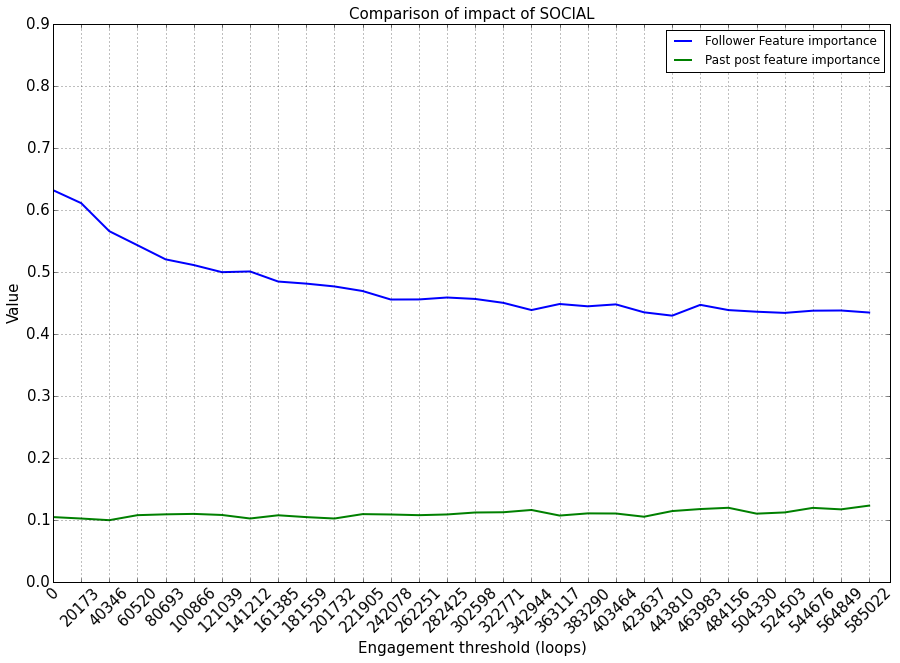

In [261]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of impact of SOCIAL", fontsize = 20)
plt.xlabel("Engagement threshold (loops)",fontsize = 20)
plt.ylabel("Value",fontsize = 20)

follower_feature_importance = [feature_importance_total[i,27] for i in range(feature_importance_total.shape[0])]
pastPosts_feature_importance = [feature_importance_total[i,28] for i in range(feature_importance_total.shape[0])]
print len(content_feature_importance)
#x = np.array(np.arange(0.2*medianPopReposts , 1.5*medianPopReposts , (1.5*medianPopReposts-0.2*medianPopReposts)/steps))

plt.plot(x , follower_feature_importance,linewidth = 2)
plt.plot(x , pastPosts_feature_importance,linewidth = 2)
plt.yticks(np.arange(0,1,0.1) , fontsize =  20 )
plt.xticks( x ,rotation=45 , fontsize =  20 )
plt.grid(True)
plt.legend(['Follower Feature importance', 'Past post feature importance', 
           ])
plt.show()

In [262]:
print indexAesthetic
print indexAudio

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0]


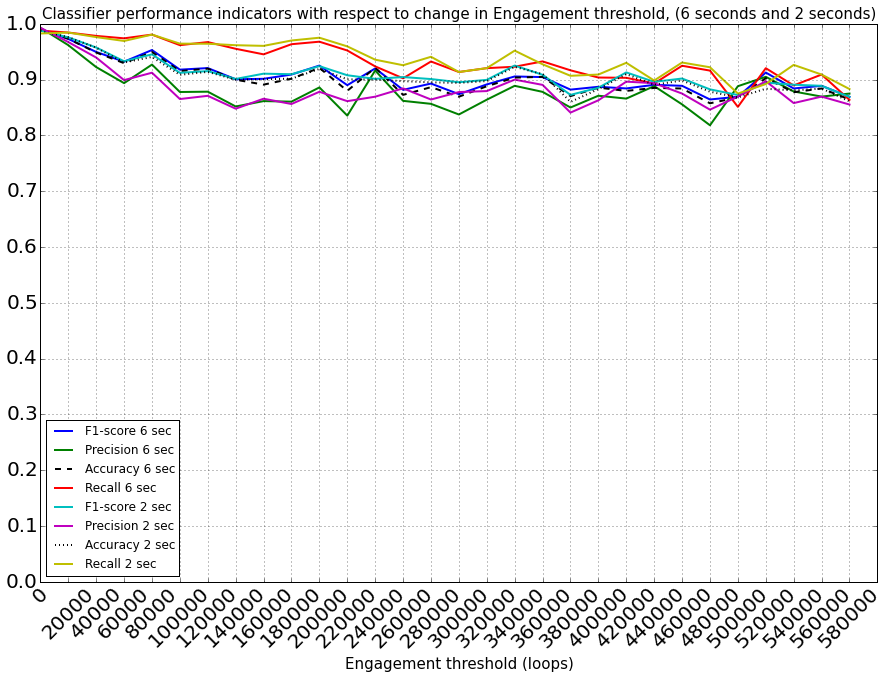

In [272]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Classifier performance indicators with respect to change in Engagement threshold, (6 seconds and 2 seconds)", fontsize = 15)
plt.xlabel("Engagement threshold (loops)",fontsize = 15)
plt.ylabel("",fontsize = 20)

#x = np.array(np.arange(0.2*medianPopReposts , 1.5*medianPopReposts , (1.5*medianPopReposts-0.2*medianPopReposts)/steps))

#plt.plot(x[:-2] , accuracies_total[:-2],linewidth = 1.5)
#plt.plot(x[:-2] , errors_total[:-2],linewidth = 1.5)
plt.plot(x[:] , fscores_total[:],linewidth = 2)
plt.plot(x[:] , precision_total[:],linewidth = 2)
plt.plot(x[:] , accuracies_total[:],linewidth = 2 , ls = 'dashed' , color = 'black')
plt.plot(x[:] , recall_total[:],linewidth = 2)

plt.plot(x[:] , fscores_total_thirds[:],linewidth = 2)
plt.plot(x[:] , precision_total_thirds[:],linewidth = 2)
plt.plot(x[:] , accuracies_total_thirds[:],linewidth = 2, ls = 'dotted' , color = 'black')
plt.plot(x[:] , recall_total_thirds[:],linewidth = 2)

plt.yticks(y, fontsize =  20 )
plt.xticks( x , rotation=45, fontsize =  20  )
plt.legend(['F1-score 6 sec', 'Precision 6 sec', 'Accuracy 6 sec', 'Recall 6 sec', \
            'F1-score 2 sec', 'Precision 2 sec', 'Accuracy 2 sec', 'Recall 2 sec'      
           ] , loc = 3)
plt.grid(True)
plt.show()

In [ ]:
corr_loopLike , corr_likeRepo , corr_repoLoop = findIterativeCorrelations(labelNumbers , 2, 80  , 1*medianPopLoops , 25 )

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Variation of correlations between popularity indices with respect to change in threshold", fontsize = 15)
plt.xlabel("Popularity threshold Ranging from Median of entire dataset to Median of gold standard ",fontsize = 15)
plt.ylabel("Pearson Correlation coeff.",fontsize = 15)
plt.plot(corr_loopLike,linewidth = 1.5)
plt.plot(corr_likeRepo,linewidth = 1.5)
plt.plot(corr_repoLoop,linewidth = 1.5)

plt.legend(['Corr Between Loops and Likes', 'Corr Between Likes and Reposts', 'Corr Between Reposts and Loops'   
           ])
plt.grid(True)
plt.show()

In [ ]:

scipy.stats.pearsonr(FeatureMatrix[:,26] , labelNumbers[:,2] )

In [ ]:
faceCorrs , facePvalues = findIterativeCorrelations(FeatureMatrix , labelNumbers , 0, 20, 80.0 , 1.5*medianPopLoops, 30 )

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Variation of correlations between popularity indices with respect to change in threshold", fontsize = 15)
plt.xlabel("Popularity threshold Ranging from Median of entire dataset to Median of gold standard ",fontsize = 15)
plt.ylabel("Pearson Correlation coeff.",fontsize = 15)
plt.plot(faceCorrs,linewidth = 1.5)

plt.legend(['Corr Between Loops and Likes', 'Corr Between Likes and Reposts', 'Corr Between Reposts and Loops'   
           ])
plt.grid(True)
plt.show()